# Relax Inc. Data Science Sample Take Home Challenge
This is a practice take home challenge from Relax Inc.
​
The data is available as two attached CSV files:
takehome_user_engagement. csv
takehome_users . csv
The data has the following two tables:
1. A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
* name: the user's name
* object_id: the user's id
* email: email address
* creation_source: how their account was created. This takes on one of 5 values:
    * PERSONAL_PROJECTS: invited to join another user's personal workspace
    * GUEST_INVITE: invited to an organization as a guest (limited permissions)
    * ORG_INVITE: invited to an organization (as a full member)
    * SIGNUP: signed up via the website
    * SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
* creation_time: when they created their account
* last_session_creation_time: unix timestamp of last login
* opted_in_to_mailing_list: whether they have opted into receiving marketing emails
* enabled_for_marketing_drip: whether they are on the regular marketing email drip
* org_id: the organization (group of users) they belong to
* invited_by_user_id: which user invited them to join (if applicable).


A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.
​
​
Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday period , identify which factors predict future user adoption .
​
​
We suggest spending 12
hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better no
more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import Counter

%matplotlib inline

In [2]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1',parse_dates=True)
user_engagement_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)
users_df.head(5)
user_engagement_df.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
print(f"Total number of users: {len(user_engagement_df['user_id'].unique())}")
print(f"Number of users signed up: {len(users_df['object_id'].unique())}")
print(f"Missing users: {len(users_df['object_id'].unique()) - len(user_engagement_df['user_id'].unique())}")
print(f"Users with missing last session info: {len(users_df[users_df['last_session_creation_time'].isnull()])}")

Total number of users: 8823
Number of users signed up: 12000
Missing users: 3177
Users with missing last session info: 3177


3177 users installed the app but never sued it.
We have two datasets that will serve two different purposes: 
1. The first dataset, takehome_user_engagement.csv, will be used to determine whether any particular user is an adopted user or not (a user who has logged into the product on three separate days in at least one seven day period). 
2. The second dataset can then be used with the determined adopted user labels to create a classification model.

In [4]:
user_engagement_df.info()
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
# Assing correct datatype to time_stamp
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])

In [6]:
# # To classify user as adopted, he/she has to be active atleast 3 times in last 7 days

seven_days = datetime.timedelta(7)
adopted_dict = {}

for user_id in sorted(list(user_engagement_df['user_id'].unique())):
    
    adopted_user = False
    temp = user_engagement_df[user_engagement_df['user_id'] == user_id].sort_values('time_stamp').reset_index()
    for i in range(len(temp)):
        if adopted_user is not True:
            this_time = temp.loc[i, 'time_stamp']
            if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp'] <= (this_time + seven_days))]) >= 3:
                adopted_user = True
        adopted_dict[user_id] = adopted_user


In [8]:
# Explore the user adoption labels
count_df = pd.DataFrame.from_dict(Counter(list(adopted_dict.values())), orient='index').reset_index()
count_df
print(f'Out of {len(adopted_dict)} users {count_df.loc[1][1]} users ie. {round(count_df.loc[1][1]/(count_df.loc[1][1]+count_df.loc[0][1])*100, 2)}% of users who have used the application are considered \'adopted users\'')

,index,0
0,False,7167
1,True,1656


Out of 8823 users 1656 users ie. 18.77% of users who have used the application are considered 'adopted users'


In [12]:
# Add target variable
count_df = pd.DataFrame.from_dict(adopted_dict, orient='index').reset_index()
count_df.columns = ['user_id', 'adopted']
users_df = pd.merge(users_df, count_df, left_on = 'object_id', right_on = 'user_id', how='left')
users_df[['adopted']] = users_df[['adopted']].fillna(value=False)

In [14]:
print(f"Out of all users who have signed up for the application {round(len(users_df[users_df['adopted'] == True])/len(users_df)*100, 2)} are considered \'adopted users\'.")

Out of all users who have signed up for the application 13.8 are considered 'adopted users'.


In [15]:
# overview of features
for feature in ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    print(f'{feature} feature:')
    print(users_df[feature].value_counts(), end='\n\n')

creation_source feature:
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

opted_in_to_mailing_list feature:
0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip feature:
0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64



,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,GUEST_INVITE,1.0,0.0,11.0,False
1,ORG_INVITE,0.0,0.0,1.0,True
2,ORG_INVITE,0.0,0.0,94.0,False
3,GUEST_INVITE,0.0,0.0,1.0,False
4,GUEST_INVITE,0.0,0.0,193.0,False


Text(0,0.5,'')

Text(0.5,1,'Adopted vs. Not-Adopted Users')

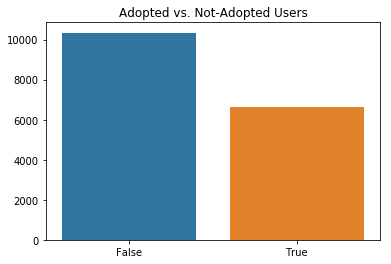

In [18]:
# Download Weka https://sourceforge.net/projects/weka/
header = ["creation_source", "opted_in_to_mailing_list", "enabled_for_marketing_drip", "org_id", "adopted"]
users_df.to_csv("input_for_weka.csv", columns = header, index=False)
# How to convert cvs to weka format 
# https://machinelearningmastery.com/load-csv-machine-learning-data-weka/

# Load output of weka SMOTE-d 
users_df_edit = pd.read_csv('output_of_weka.csv')
users_df_edit.head()

sns.barplot(x = list(users_df_edit['adopted'].value_counts().index), 
            y = users_df_edit['adopted'].value_counts())
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users')

In [19]:
users_df_edit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16968 entries, 0 to 16967
Data columns (total 5 columns):
creation_source               16968 non-null object
opted_in_to_mailing_list      16968 non-null float64
enabled_for_marketing_drip    16968 non-null float64
org_id                        16968 non-null float64
adopted                       16968 non-null bool
dtypes: bool(1), float64(3), object(1)
memory usage: 546.9+ KB


In [20]:
# modeling
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

# One-hot-enacode
df_encoded = pd.get_dummies(users_df_edit, columns = ['creation_source'])
df_encoded.head()

C:\Users\kdeodhar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\kdeodhar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.0,0.0,11.0,False,1,0,0,0,0
1,0.0,0.0,1.0,True,0,1,0,0,0
2,0.0,0.0,94.0,False,0,1,0,0,0
3,0.0,0.0,1.0,False,1,0,0,0,0
4,0.0,0.0,193.0,False,1,0,0,0,0


In [21]:
# Split into train and test sets

train, test = train_test_split(df_encoded, test_size=.20, 
                               random_state=42, stratify=df_encoded['adopted'])

train.reset_index(drop=True, inplace=True)
target = train['adopted']
train = train.drop('adopted', axis=1)

test.reset_index(drop=True, inplace=True)
test_target = test['adopted']
test = test.drop('adopted', axis=1)

train.shape
test.shape

(13574, 8)

(3394, 8)

In [22]:
# cross validation on the training set

clf = RandomForestClassifier()
cv = cross_validation.KFold(len(train), n_folds=10)

cv_count = 1
for traincv, testcv in cv:  
        preds = clf.fit(train.loc[list(traincv),:], 
                        target.loc[list(traincv),]).predict(train.loc[list(testcv),:])
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.loc[testcv,], preds)

        print(cv_count, 
              accuracy_score(target.loc[testcv,], preds)*100, 
              auc(false_positive_rate, true_positive_rate),
              confusion_matrix(target.loc[testcv,], preds))
        cv_count += 1

1 77.90868924889544 0.7615752239286694 [[694 127]
 [173 364]]
2 79.82326951399116 0.784303091877643 [[705 129]
 [145 379]]
3 78.4977908689249 0.7700394843251986 [[690 129]
 [163 376]]
4 79.16053019145802 0.775086587706249 [[702 121]
 [162 373]]
5 77.96610169491525 0.7640259890938624 [[702 148]
 [151 356]]
6 79.51363301400147 0.780975282534052 [[697 125]
 [153 382]]
7 79.58732498157701 0.7755917104884857 [[727 122]
 [155 353]]
8 78.48194546794399 0.769624060150376 [[693 132]
 [160 372]]
9 78.7030213706706 0.7725203684823111 [[686 123]
 [166 382]]
10 77.59764185703759 0.7590856963425123 [[690 133]
 [171 363]]


77% Accuracy on training set

In [23]:
# Test on test set
final_clf = clf.fit(train, target)
test_preds = final_clf.predict(test)

print(accuracy_score(test_target, test_preds)*100, 
                  confusion_matrix(test_target, test_preds))

79.22804949911608 [[1755  314]
 [ 391  934]]


79% Accuracy on test set

In [24]:
# Important features
umportant_features = pd.DataFrame(final_clf.feature_importances_).T
umportant_features.columns = list(train.columns)
umportant_features = umportant_features.T
umportant_features.columns = ['feature_importance']
umportant_features.sort_values('feature_importance', ascending=False)

,feature_importance
org_id,0.736831
opted_in_to_mailing_list,0.093773
enabled_for_marketing_drip,0.083336
creation_source_PERSONAL_PROJECTS,0.041504
creation_source_ORG_INVITE,0.020830
creation_source_GUEST_INVITE,0.014981
creation_source_SIGNUP,0.005581
creation_source_SIGNUP_GOOGLE_AUTH,0.003163


## Conclusion:
Organization ID is the most predictive feature for determining future user adoption, and this was followed by whether a user opted in to the marketing email list, whether a user was enabled for marketing email drip. 